# ALGORITMOS BASADOS EN SERIES TEMPORALES

## A) Recopilación de Funciones

Se compilan los Algoritmos Probados

In [1]:
# LIBRERIAS NECESARIAS 
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pyodbc
from dotenv import dotenv_values
import psycopg2 as pg2    # Conectores para Postgres
import getpass  # Para obtener el usuario del sistema operativo

# Mostrar el DataFrame resultante
import ace_tools_open as tools

# Evitar Mensajes Molestos
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category= FutureWarning)

# Liberias para Algoritmos
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

secrets = dotenv_values(".env")   # Connection String from .env
folder = secrets["FOLDER_DATOS"]


In [ ]:
# FUNCIONES OPTIMIZADA PARA EL PRONOSTICO DE DEMANDA
# Trataremos de Estandarizar las salidas y optimizar el proceso
# Generaremos datos para regenerar graficos simples al vuelo y grabaremos un gráfico ya precalculado
# En esta primera etapa en un blob64, luego en un servidor de archivos con un link.

###----------------------------------------------------------------
#     DATOS
###----------------------------------------------------------------
def Open_Connection():
    secrets = dotenv_values(".env")   # Connection String from .env
    conn_str = f'DRIVER={secrets["DRIVER2"]};SERVER={secrets["SERVIDOR2"]};PORT={secrets["PUERTO2"]};DATABASE={secrets["BASE2"]};UID={secrets["USUARIO2"]};PWD={secrets["CONTRASENA2"]}'
    # print (conn_str) 
    try:    
        conn = pyodbc.connect(conn_str)
        return conn
    except:
        print('Error en la Conexión')
        return None

def Open_Conn_Postgres():
    secrets = dotenv_values(".env")   # Cargar credenciales desde .env    
    conn_str = f"dbname={secrets['BASE3']} user={secrets['USUARIO3']} password={secrets['CONTRASENA3']} host={secrets['SERVIDOR3']} port={secrets['PUERTO3']}"
    #print (conn_str)
    try:    
        conn = pg2.connect(conn_str)
        return conn
    except Exception as e:
        print(f'Error en la conexión: {e}')
        return None
    
def Close_Connection(conn): 
    conn.close()
    return True

def generar_datos(id_proveedor, etiqueta, ventana):
    secrets = dotenv_values(".env")   # Connection String from .env
    folder = secrets["FOLDER_DATOS"]
    
    #  Intento recuperar datos cacheados
    try:
        data = pd.read_csv(f'{folder}/{etiqueta}.csv')
        data['Codigo_Articulo']= data['Codigo_Articulo'].astype(int)
        data['Sucursal']= data['Sucursal'].astype(int)
        data['Fecha']= pd.to_datetime(data['Fecha'])

        articulos = pd.read_csv(f'{folder}/{etiqueta}_articulos.csv')
        #articulos.head()
        print(f"-> Datos Recuperados del CACHE: {id_proveedor}, Label: {etiqueta}")
        return data, articulos
    except:     
        print(f"-> Generando datos para ID: {id_proveedor}, Label: {etiqueta}")
        # Configuración de conexión
        conn = Open_Connection()
        
        # ----------------------------------------------------------------
        # FILTRA solo PRODUCTOS HABILITADOS y Traer datos de STOCK y PENDIENTES desde PRODUCCIÓN
        # ----------------------------------------------------------------
        query = f"""
            SELECT A.[C_PROVEEDOR_PRIMARIO]
            ,S.[C_ARTICULO]
            ,S.[C_SUCU_EMPR]
			--,R.[C_SUCU_EMPR]
			--,R.[C_ARTICULO]
            ,S.[I_PRECIO_VTA]
            ,S.[I_COSTO_ESTADISTICO]
            ,S.[Q_FACTOR_VENTA_ESP]
            ,S.[Q_FACTOR_VTA_SUCU]
            ,S.[M_OFERTA_SUCU]
            ,S.[M_HABILITADO_SUCU]
            ,A.M_BAJA
            ,S.[Q_VTA_DIA_ANT]
            ,S.[Q_VTA_ACUM]
            ,S.[Q_ULT_ING_STOCK]
            ,S.[Q_STOCK_A_ULT_ING]
            ,S.[Q_15DIASVTA_A_ULT_ING_STOCK]
            ,S.[Q_30DIASVTA_A_ULT_ING_STOCK]
            ,S.[Q_BULTOS_PENDIENTE_OC]
            ,S.[Q_PESO_PENDIENTE_OC]
            ,S.[Q_UNID_PESO_PEND_RECEP_TRANSF]
            ,S.[Q_UNID_PESO_VTA_MES_ACTUAL]
            ,S.[F_ULTIMA_VTA]
            ,S.[Q_VTA_ULTIMOS_15DIAS]
            ,S.[Q_VTA_ULTIMOS_30DIAS]
            ,S.[Q_TRANSF_PEND]
            ,S.[Q_TRANSF_EN_PREP]
            ,S.[M_FOLDER]
            ,S.[M_ALTA_RENTABILIDAD]
            ,S.[Lugar_Abastecimiento]
            ,S.[M_COSTO_LOGISTICO]
            ,A.[N_ARTICULO]
            ,A.[C_FAMILIA]
            ,A.[C_RUBRO]

            ,R.[Q_VENTA_30_DIAS]
            ,R.[Q_VENTA_15_DIAS]
            ,R.[Q_VENTA_DOMINGO]
            ,R.[Q_VENTA_ESPECIAL_30_DIAS]
            ,R.[Q_VENTA_ESPECIAL_15_DIAS]
            ,R.[Q_DIAS_CON_STOCK]
            ,R.[Q_REPONER]
            ,R.[Q_REPONER_INCLUIDO_SOBRE_STOCK]

            ,R.[Q_VENTA_DIARIA_NORMAL]
            ,R.[Q_DIAS_STOCK]
            ,R.[Q_DIAS_SOBRE_STOCK]
            ,R.[Q_DIAS_ENTREGA_PROVEEDOR]
        
        FROM [DIARCOP001].[DiarcoP].[dbo].[T051_ARTICULOS_SUCURSAL] S
        LEFT JOIN [DIARCOP001].[DiarcoP].[dbo].[T050_ARTICULOS] A
            ON A.[C_ARTICULO] = S.[C_ARTICULO]
        LEFT JOIN [DIARCOP001].[DiarcoP].[dbo].[T055_ARTICULOS_PARAM_STOCK] P
            ON P.[C_SUCU_EMPR] = S.[C_SUCU_EMPR]
            AND P.[C_FAMILIA] =A.[C_FAMILIA]
		LEFT JOIN [DIARCOP001].[DiarcoP].[dbo].[T710_ESTADIS_REPOSICION] R
			ON R.[C_ARTICULO] = S.[C_ARTICULO]
			AND R.[C_SUCU_EMPR] = S.[C_SUCU_EMPR]

        WHERE S.[M_HABILITADO_SUCU] = 'S' -- Permitido Reponer
            AND A.M_BAJA = 'N'  -- Activo en Maestro Artículos
            AND A.[C_PROVEEDOR_PRIMARIO] = {id_proveedor} -- Solo del Proveedor
        
        ORDER BY S.[C_ARTICULO],S.[C_SUCU_EMPR];
        """
        # Ejecutar la consulta SQL
        articulos = pd.read_sql(query, conn)
        file_path = f'{folder}/{etiqueta}_Articulos.csv'
        articulos['C_PROVEEDOR_PRIMARIO']= articulos['C_PROVEEDOR_PRIMARIO'].astype(int)
        articulos['C_ARTICULO']= articulos['C_ARTICULO'].astype(int)
        articulos['C_FAMILIA']= articulos['C_FAMILIA'].astype(int)
        articulos['C_RUBRO']= articulos['C_RUBRO'].astype(int)
            # Convertir a enteros y reemplazar valores nulos por el valor de ventana
        articulos['Q_DIAS_STOCK'] = articulos['Q_DIAS_STOCK'].fillna(ventana).astype(int)
        articulos['Q_DIAS_SOBRE_STOCK'] = articulos['Q_DIAS_SOBRE_STOCK'].fillna(0).astype(int)
        articulos.to_csv(file_path, index=False, encoding='utf-8')        
        print(f"---> Datos de Artículos guardados: {file_path}")
        
        # ----------------------------------------------------------------
        # Consulta SQL para obtener las VENTAS de un proveedor específico   
        # Reemplazar {proveedor} en la consulta con el ID de la tienda actual
        # ----------------------------------------------------------------
        query = f"""
        SELECT V.[F_VENTA] as Fecha
            ,V.[C_ARTICULO] as Codigo_Articulo
            ,V.[C_SUCU_EMPR] as Sucursal
            ,V.[I_PRECIO_VENTA] as Precio
            ,V.[I_PRECIO_COSTO] as Costo
            ,V.[Q_UNIDADES_VENDIDAS] as Unidades
            ,V.[C_FAMILIA] as Familia
            ,A.[C_RUBRO] as Rubro
            ,A.[C_SUBRUBRO_1] as SubRubro
            ,LTRIM(RTRIM(REPLACE(REPLACE(REPLACE(A.N_ARTICULO, CHAR(9), ''), CHAR(13), ''), CHAR(10), ''))) as Nombre_Articulo
            ,A.[C_CLASIFICACION_COMPRA] as Clasificacion
        FROM [DCO-DBCORE-P02].[DiarcoEst].[dbo].[T702_EST_VTAS_POR_ARTICULO] V
        LEFT JOIN [DCO-DBCORE-P02].[DiarcoEst].[dbo].[T050_ARTICULOS] A 
            ON V.C_ARTICULO = A.C_ARTICULO
        WHERE A.[C_PROVEEDOR_PRIMARIO] = {id_proveedor} AND V.F_VENTA >= '20210101' AND A.M_BAJA ='N'
        ORDER BY V.F_VENTA ;
        """

        # Ejecutar la consulta SQL
        demanda = pd.read_sql(query, conn)
        
        # UNIR Y FILTRAR solo la demanda de los Hartículos VALIDOS.
        # Realizar la unión (merge) de los DataFrames por las claves especificadas
        data = pd.merge(
            articulos,  # DataFrame de artículos
            demanda,    # DataFrame de demanda
            left_on=['C_ARTICULO', 'C_SUCU_EMPR'],  # Claves en 'articulos'
            right_on=['Codigo_Articulo', 'Sucursal'],  # Claves en 'demanda'
            how='inner'  # Solo traer los productos que están en 'articulos'
        )
            
        # Guardar los resultados en un archivo CSV con el nombre del Proveedor
        # en el  mismo formato que hubiera generado el Query.
        # Esto se utilizaría como cache de datos.

        file_path = f'{folder}/{etiqueta}.csv'
        data['C_ARTICULO']= data['C_ARTICULO'].astype(int)
        data['C_SUCU_EMPR']= data['C_SUCU_EMPR'].astype(int)
        data['C_FAMILIA']= articulos['C_FAMILIA'].astype(int)
        data['C_RUBRO']= articulos['C_RUBRO'].astype(int)
        data['Codigo_Articulo']= data['Codigo_Articulo'].astype(int)
        data['Sucursal']= data['Sucursal'].astype(int)
        data.to_csv(file_path, index=False, encoding='utf-8')
        print(f"---> Datos de Ventas guardados: {file_path}")  

        # Eliminar Columnas Innecesarias
        data = data[['Fecha', 'Codigo_Articulo', 'Sucursal', 'Unidades']]
        
        # Guardar los datos Compactos de VENTAS en un archivo CSV con el nombre del Proveedor y sufijo _Ventas
        file_path = f'{folder}/{etiqueta}_Ventas.csv'
        data.to_csv(file_path, index=False, encoding='utf-8')
        
        # Cerrar la conexión después de la iteración
        Close_Connection(conn)
        return data, articulos

def Exportar_Pronostico(df_forecast, proveedor, etiqueta, algoritmo):
    df_forecast['Codigo_Articulo']= df_forecast['Codigo_Articulo'].astype(int)
    df_forecast['Sucursal']= df_forecast['Sucursal'].astype(int)
    
    # tools.display_dataframe_to_user(name="SET de Datos del Proveedor", dataframe=df_forecast)
    # df_forecast.info()
    #print(f'-> ** Pronostico Guardado en: {folder}/{etiqueta}_{algoritmo}_Pronostico.csv **')
    #df_forecast.to_csv(f'{folder}/{etiqueta}_{algoritmo}_Pronostico.csv', index=False)
    
    ## GUARDAR TABLA EN POSTGRES
    usuario = getpass.getuser()  # Obtiene el usuario del sistema operativo
    fecha_actual = datetime.today().strftime('%Y-%m-%d')  # Obtiene la fecha de hoy en formato 'YYYY-MM-DD'
    conn = Open_Conn_Postgres()
    
    # Query de inserción
    insert_query = """
    INSERT INTO public.f_oc_precarga_connexa (
        c_proveedor, c_articulo, c_sucu_empr, q_forecast_unidades, f_alta_forecast, c_usuario_forecast, create_date
    ) VALUES (%s, %s, %s, %s, %s, %s, %s);
    """

    # Convertir el DataFrame a una lista de tuplas para la inserción en bloque
    data_to_insert = [
        (proveedor, row['Codigo_Articulo'], row['Sucursal'], row['Forecast'], fecha_actual, usuario, fecha_actual)
        for _, row in df_forecast.iterrows()
    ]

    try:
        with conn.cursor() as cur:
            cur.executemany(insert_query, data_to_insert)
        conn.commit()
        print(f"✅ Inserción completada: {len(data_to_insert)} registros insertados.")
    except Exception as e:
        conn.rollback()
        print(f"❌ Error en la inserción: {e}")
    finally:
        Close_Connection(conn)
        print("✅ Conexión cerrada.")

###----------------------------------------------------------------
#     ALGORITMOS
###----------------------------------------------------------------
# ALGO_01 Promedio de Ventas Ponderado 
###---------------------------------------------------------------- 
def Calcular_Demanda_ALGO_01(df, id_proveedor, etiqueta, period_length, current_date, factor_last, factor_previous, factor_year):
    print('Dentro del Calcular_Demanda_ALGO_01')
    print(f'FORECAST control: {id_proveedor} - {etiqueta} - ventana: {period_length} - factores: {factor_last} - {factor_previous} - {factor_year}')
    # Definir rangos de fechas para cada período
    last_period_start = current_date - pd.Timedelta(days=period_length - 1)
    last_period_end = current_date

    previous_period_start = current_date - pd.Timedelta(days=2 * period_length - 1)
    previous_period_end = current_date - pd.Timedelta(days=period_length)

    same_period_last_year_start = current_date - pd.DateOffset(years=1) - pd.Timedelta(days=period_length - 1)
    same_period_last_year_end = current_date - pd.DateOffset(years=1)

    # Filtrar los datos para cada uno de los períodos
    df_last = df[(df['Fecha'] >= last_period_start) & (df['Fecha'] <= last_period_end)]
    df_previous = df[(df['Fecha'] >= previous_period_start) & (df['Fecha'] <= previous_period_end)]
    df_same_year = df[(df['Fecha'] >= same_period_last_year_start) & (df['Fecha'] <= same_period_last_year_end)]

    # Agregar las ventas (unidades) por artículo y sucursal para cada período
    sales_last = df_last.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                        .sum().reset_index().rename(columns={'Unidades': 'ventas_last'})
    sales_previous = df_previous.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_previous'})
    sales_same_year = df_same_year.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_same_year'})

    # Unir la información de los tres períodos
    df_forecast = pd.merge(sales_last, sales_previous, on=['Codigo_Articulo', 'Sucursal'], how='outer')
    df_forecast = pd.merge(df_forecast, sales_same_year, on=['Codigo_Articulo', 'Sucursal'], how='outer')
    df_forecast.fillna(0, inplace=True)

    # Calcular la demanda estimada como el promedio de las ventas de los tres períodos
    df_forecast['Forecast'] = (df_forecast['ventas_last'] * factor_last +
                               df_forecast['ventas_previous'] * factor_previous +
                               df_forecast['ventas_same_year'] * factor_year) / (factor_year + factor_last + factor_previous)

    # Redondear la predicción al entero más cercano  y eliminar los Negativos
    df_forecast['Forecast'] = np.ceil(df_forecast['Forecast']).clip(lower=0)
    df_forecast['Average'] = round(df_forecast['Forecast'] /period_length ,3)
    # Agregar las columnas id_proveedor y ventana
    df_forecast['id_proveedor'] = id_proveedor
    df_forecast['ventana'] = period_length
    df_forecast['algoritmo'] = 'ALGO_01'

    # Reordenar las columnas según la especificación
    df_forecast = df_forecast[['id_proveedor', 'Codigo_Articulo', 'Sucursal',  'algoritmo', 'ventana', 'Forecast', 
                            'Average','ventas_last', 'ventas_previous', 'ventas_same_year']]
    return df_forecast


    # Borrar Columnas Innecesarias
    # forecast_df.drop(columns=['ventas_last', 'ventas_previous', 'ventas_same_year'], inplace=True)

###----------------------------------------------------------------
# ALGO_02 Doble Exponencial -  Modelo Holt (TENDENCIA)
###----------------------------------------------------------------
def Calcular_Demanda_ALGO_02(df, id_proveedor, etiqueta, ventana, current_date):
    print('Dentro del Calcular_Demanda_ALGO_02')
    print(f'FORECAST Holt control: {id_proveedor} - {etiqueta} - ventana: {ventana} ')

        # Ajustar el modelo Holt-Winters: 
        # - trend: 'add' para tendencia aditiva
        # - seasonal: 'add' para estacionalidad aditiva
        # - seasonal_periods: 7 (para estacionalidad semanal)
    # Configurar la ventana de pronóstico (por ejemplo, 30 días o 45 días)
    #forecast_window = 30  # Cambia a 45 si es necesario
    # Lista para almacenar los resultados del forecast
    resultados = []
    
    # Definir rangos de fechas para cada período
    last_period_start = current_date - pd.Timedelta(days=ventana - 1)
    last_period_end = current_date

    previous_period_start = current_date - pd.Timedelta(days=2 * ventana - 1)
    previous_period_end = current_date - pd.Timedelta(days=ventana)

    same_period_last_year_start = current_date - pd.DateOffset(years=1) - pd.Timedelta(days=ventana - 1)
    same_period_last_year_end = current_date - pd.DateOffset(years=1)

    # Filtrar los datos para cada uno de los períodos
    df_last = df[(df['Fecha'] >= last_period_start) & (df['Fecha'] <= last_period_end)]
    df_previous = df[(df['Fecha'] >= previous_period_start) & (df['Fecha'] <= previous_period_end)]
    df_same_year = df[(df['Fecha'] >= same_period_last_year_start) & (df['Fecha'] <= same_period_last_year_end)]

    # Agregar las ventas (unidades) por artículo y sucursal para cada período
    sales_last = df_last.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                        .sum().reset_index().rename(columns={'Unidades': 'ventas_last'})
    sales_previous = df_previous.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_previous'})
    sales_same_year = df_same_year.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_same_year'})

    # Agrupar los datos por 'Codigo_Articulo' y 'Sucursal'
    for (codigo, sucursal), grupo in df.groupby(['Codigo_Articulo', 'Sucursal']):
        # Ordenar cronológicamente y fijar 'Fecha' como índice
        grupo = grupo.set_index('Fecha').sort_index()
        
        # Resamplear a frecuencia diaria sumando las ventas y rellenando días sin datos
        ventas_diarias = grupo['Unidades'].resample('D').sum().fillna(0)
        
        # Verificar que la serie tenga suficientes datos para ajustar el modelo
        if len(ventas_diarias) < 2 * 7:  # por ejemplo, al menos dos ciclos de la estacionalidad semanal
            continue

        try:
            # Ajustar el modelo Holt
            # - trend: 'add' para tendencia aditiva
            # - seasonal: 'add' para estacionalidad aditiva
            # - seasonal_periods: 7 (para estacionalidad semanal)
            modelo = Holt(ventas_diarias)
            modelo_ajustado = modelo.fit(optimized=True)
            
            # Realizar el forecast para la ventana definida
            pronostico = modelo_ajustado.forecast(ventana)
            
            # La demanda esperada es la suma de las predicciones diarias en el periodo
            forecast_total = pronostico.sum()
        except Exception as e:
            # Si ocurre algún error en el ajuste, puedes asignar un valor nulo o manejarlo de otra forma
            forecast_total = None
        
        resultados.append({
            'Codigo_Articulo': codigo,
            'Sucursal': sucursal,
            'Forecast': round(forecast_total, 2) if forecast_total is not None else None
        })

    # Crear el DataFrame final con los resultados del forecast
    df_forecast = pd.DataFrame(resultados)
    # Redondear la predicción al entero más cercano
    df_forecast['Forecast'] = np.ceil(df_forecast['Forecast']).clip(lower=0)
    df_forecast['Average'] = round(df_forecast['Forecast'] /ventana ,3)
    
        # Agregar las columnas id_proveedor y ventana
    df_forecast['id_proveedor'] = id_proveedor
    df_forecast['ventana'] = ventana
    df_forecast['algoritmo'] = 'ALGO_02'
    
        # Unir las ventas de los períodos con el forecast
    df_forecast = pd.merge(df_forecast, sales_last, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast = pd.merge(df_forecast, sales_previous, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast = pd.merge(df_forecast, sales_same_year, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast.fillna(0, inplace=True)

    # Reordenar las columnas según la especificación
    df_forecast = df_forecast[['id_proveedor', 'Codigo_Articulo', 'Sucursal', 'algoritmo', 'ventana', 'Forecast', 
                            'Average', 'ventas_last', 'ventas_previous', 'ventas_same_year']]
    
    return df_forecast

###----------------------------------------------------------------
# ALGO_03 Suavizado Exponencial -  Modelo Holt-Winters (TENDENCIA + ESTACIONALIDAD)
###----------------------------------------------------------------
def Calcular_Demanda_ALGO_03(df, id_proveedor, etiqueta, ventana, current_date, periodos, f2, f3):
    print('Dentro del Calcular_Demanda_ALGO_03')
    print(f'FORECAST control: {id_proveedor} - {etiqueta} - ventana: {ventana} - factores: Períodos Estacionalidad  {periodos} - Tendencia: {f2} - Estacionalidad: {f3}')

        # Ajustar el modelo Holt-Winters: 
        # - trend: 'add' para tendencia aditiva
        # - seasonal: 'add' para estacionalidad aditiva
        # - seasonal_periods: 7 (para estacionalidad semanal)
    # Configurar la ventana de pronóstico (por ejemplo, 30 días o 45 días)
    #forecast_window = 30  # Cambia a 45 si es necesario
    # Lista para almacenar los resultados del forecast
    resultados = []
    
    # Definir rangos de fechas para cada período
    last_period_start = current_date - pd.Timedelta(days=ventana - 1)
    last_period_end = current_date

    previous_period_start = current_date - pd.Timedelta(days=2 * ventana - 1)
    previous_period_end = current_date - pd.Timedelta(days=ventana)

    same_period_last_year_start = current_date - pd.DateOffset(years=1) - pd.Timedelta(days=ventana - 1)
    same_period_last_year_end = current_date - pd.DateOffset(years=1)

    # Filtrar los datos para cada uno de los períodos
    df_last = df[(df['Fecha'] >= last_period_start) & (df['Fecha'] <= last_period_end)]
    df_previous = df[(df['Fecha'] >= previous_period_start) & (df['Fecha'] <= previous_period_end)]
    df_same_year = df[(df['Fecha'] >= same_period_last_year_start) & (df['Fecha'] <= same_period_last_year_end)]

    # Agregar las ventas (unidades) por artículo y sucursal para cada período
    sales_last = df_last.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                        .sum().reset_index().rename(columns={'Unidades': 'ventas_last'})
    sales_previous = df_previous.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_previous'})
    sales_same_year = df_same_year.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_same_year'})
    
    # Agrupar los datos por 'Codigo_Articulo' y 'Sucursal'
    for (codigo, sucursal), grupo in df.groupby(['Codigo_Articulo', 'Sucursal']):
        # Ordenar cronológicamente y fijar 'Fecha' como índice
        grupo = grupo.set_index('Fecha').sort_index()
        
        # Resamplear a frecuencia diaria sumando las ventas y rellenando días sin datos
        ventas_diarias = grupo['Unidades'].resample('D').sum().fillna(0)
        
        # Verificar que la serie tenga suficientes datos para ajustar el modelo
        if len(ventas_diarias) < 2 * 7:  # por ejemplo, al menos dos ciclos de la estacionalidad semanal
            continue

        try:
            # Ajustar el modelo Holt-Winters: 
            # - trend: 'add' para tendencia aditiva
            # - seasonal: 'add' para estacionalidad aditiva
            # - seasonal_periods: 7 (para estacionalidad semanal)
            modelo = ExponentialSmoothing(ventas_diarias, trend=f2, seasonal=f3, seasonal_periods=periodos)
            modelo_ajustado = modelo.fit(optimized=True)
            
            # Realizar el forecast para la ventana definida
            pronostico = modelo_ajustado.forecast(ventana)
            
            # La demanda esperada es la suma de las predicciones diarias en el periodo
            forecast_total = pronostico.sum()
        except Exception as e:
            # Si ocurre algún error en el ajuste, puedes asignar un valor nulo o manejarlo de otra forma
            forecast_total = None
        
        resultados.append({
            'Codigo_Articulo': codigo,
            'Sucursal': sucursal,
            'Forecast': round(forecast_total, 2) if forecast_total is not None else None
        })

    # Crear el DataFrame final con los resultados del forecast
    df_forecast = pd.DataFrame(resultados)
    # Redondear la predicción al entero más cercano
    df_forecast['Forecast'] = np.ceil(df_forecast['Forecast']).clip(lower=0)
    df_forecast['Average'] = round(df_forecast['Forecast'] /ventana ,3)
    
        # Agregar las columnas id_proveedor y ventana
    df_forecast['id_proveedor'] = id_proveedor
    df_forecast['ventana'] = ventana
    df_forecast['algoritmo'] = 'ALGO_03'
    
        # Unir las ventas de los períodos con el forecast
    df_forecast = pd.merge(df_forecast, sales_last, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast = pd.merge(df_forecast, sales_previous, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast = pd.merge(df_forecast, sales_same_year, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast.fillna(0, inplace=True)

    # Reordenar las columnas según la especificación
    df_forecast = df_forecast[['id_proveedor', 'Codigo_Articulo', 'Sucursal', 'algoritmo', 'ventana', 'Forecast', 
                            'Average', 'ventas_last', 'ventas_previous', 'ventas_same_year']]
    return df_forecast

###----------------------------------------------------------------
# ALGO_04 Suavizado Exponencial Simple -  Modelo de Media Movil Exponencial Ponderada (EWMA) x Factor alpha
###----------------------------------------------------------------
def Calcular_Demanda_ALGO_04(df, id_proveedor, etiqueta, ventana, current_date, alpha):
    print('Dentro del Calcular_Demanda_ALGO_04')
    print(f'FORECAST control: {id_proveedor} - {etiqueta} - ventana: {ventana} - Fator Alpha: {alpha} ')

    # Configurar la ventana de pronóstico (por ejemplo, 30 o 45 días)
    #forecast_window = 45  # Puedes cambiarlo a 45 según tus necesidades
    # Parámetro de suavizado (alpha); valores cercanos a 1 dan más peso a los datos recientes
    #alpha = 0.3

    # Lista para almacenar los resultados del forecast
    resultados = []
    
    # Definir rangos de fechas para cada período
    last_period_start = current_date - pd.Timedelta(days=ventana - 1)
    last_period_end = current_date

    previous_period_start = current_date - pd.Timedelta(days=2 * ventana - 1)
    previous_period_end = current_date - pd.Timedelta(days=ventana)

    same_period_last_year_start = current_date - pd.DateOffset(years=1) - pd.Timedelta(days=ventana - 1)
    same_period_last_year_end = current_date - pd.DateOffset(years=1)

    # Filtrar los datos para cada uno de los períodos
    df_last = df[(df['Fecha'] >= last_period_start) & (df['Fecha'] <= last_period_end)]
    df_previous = df[(df['Fecha'] >= previous_period_start) & (df['Fecha'] <= previous_period_end)]
    df_same_year = df[(df['Fecha'] >= same_period_last_year_start) & (df['Fecha'] <= same_period_last_year_end)]

    # Agregar las ventas (unidades) por artículo y sucursal para cada período
    sales_last = df_last.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                        .sum().reset_index().rename(columns={'Unidades': 'ventas_last'})
    sales_previous = df_previous.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_previous'})
    sales_same_year = df_same_year.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_same_year'})
    
    # Agrupar los datos por 'Codigo_Articulo' y 'Sucursal'
    for (codigo, sucursal), grupo in df.groupby(['Codigo_Articulo', 'Sucursal']):
        # Ordenar cronológicamente y fijar 'Fecha' como índice
        grupo = grupo.set_index('Fecha').sort_index()
        
        # Resamplear a frecuencia diaria sumando las ventas y rellenando días sin datos
        ventas_diarias = grupo['Unidades'].resample('D').sum().fillna(0)
        
        # Calcular el suavizado exponencial (EWMA) sobre la serie de ventas diarias
        ewma_series = ventas_diarias.ewm(alpha=alpha, adjust=False).mean()
        
        # Tomamos el último valor suavizado como forecast diario
        ultimo_ewma = ewma_series.iloc[-1]
        
        # El pronóstico total para la ventana definida es el pronóstico diario multiplicado por la cantidad de días
        forecast_total = ultimo_ewma * ventana
        
        resultados.append({
            'Codigo_Articulo': codigo,
            'Sucursal': sucursal,
            'Forecast': round(forecast_total, 2),
            'Average': round(ultimo_ewma, 3)
        })

    # Crear el DataFrame final con los resultados
    df_forecast = pd.DataFrame(resultados)
    # Redondear la predicción al entero más cercano y evitar negativos
    df_forecast['Forecast'] = np.ceil(df_forecast['Forecast']).clip(lower=0)
    # Agregar las columnas id_proveedor y ventana
    df_forecast['id_proveedor'] = id_proveedor
    df_forecast['ventana'] = ventana
    df_forecast['algoritmo'] = 'ALGO_04'
    
        # Unir las ventas de los períodos con el forecast
    df_forecast = pd.merge(df_forecast, sales_last, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast = pd.merge(df_forecast, sales_previous, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast = pd.merge(df_forecast, sales_same_year, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast.fillna(0, inplace=True)
    
    # Reordenar las columnas según la especificación
    df_forecast = df_forecast[['id_proveedor', 'Codigo_Articulo', 'Sucursal', 'algoritmo', 'ventana', 'Forecast', 
                            'Average', 'ventas_last', 'ventas_previous', 'ventas_same_year']]
    return df_forecast

###----------------------------------------------------------------
# ALGO_05 Promedio de Venta SIMPLE (PVS) (Metodo Actual que usan los Compradores)
###----------------------------------------------------------------
def Calcular_Demanda_ALGO_05(df, id_proveedor, etiqueta, ventana, current_date):
    # Lista para almacenar los resultados del pronóstico
    resultados = []

    # Definir rangos de fechas para cada período
    last_period_start = current_date - pd.Timedelta(days=ventana - 1)
    last_period_end = current_date

    previous_period_start = current_date - pd.Timedelta(days=2 * ventana - 1)
    previous_period_end = current_date - pd.Timedelta(days=ventana)

    same_period_last_year_start = current_date - pd.DateOffset(years=1) - pd.Timedelta(days=ventana - 1)
    same_period_last_year_end = current_date - pd.DateOffset(years=1)

    # Filtrar los datos para cada uno de los períodos
    df_last = df[(df['Fecha'] >= last_period_start) & (df['Fecha'] <= last_period_end)]
    df_previous = df[(df['Fecha'] >= previous_period_start) & (df['Fecha'] <= previous_period_end)]
    df_same_year = df[(df['Fecha'] >= same_period_last_year_start) & (df['Fecha'] <= same_period_last_year_end)]

    # Agregar las ventas (unidades) por artículo y sucursal para cada período
    sales_last = df_last.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                        .sum().reset_index().rename(columns={'Unidades': 'ventas_last'})
    sales_previous = df_previous.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_previous'})
    sales_same_year = df_same_year.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_same_year'})
    
    # Agrupar los datos por 'Codigo_Articulo' y 'Sucursal'
    for (codigo, sucursal), grupo in df.groupby(['Codigo_Articulo', 'Sucursal']):
        # Establecer 'Fecha' como índice y ordenar los datos
        grupo = grupo.set_index('Fecha').sort_index()
        
        # Resamplear a diario sumando las ventas
        ventas_diarias = grupo['Unidades'].resample('D').sum().fillna(0)
        
        # Seleccionar un periodo reciente para calcular la media; por ejemplo, los últimos 30 días
        # Si hay menos de 30 días de datos, se utiliza el periodo disponible
        ventas_recientes = ventas_diarias[-30:]
        media_diaria = ventas_recientes.mean()
        
        # Pronosticar la demanda para el periodo de reposición
        pronostico = media_diaria * ventana
        
        resultados.append({
            'Codigo_Articulo': codigo,
            'Sucursal': sucursal,
            'Forecast': round(pronostico, 2),
            'Average': round(media_diaria, 3)
        })

    # Crear el DataFrame de pronósticos
    df_forecast = pd.DataFrame(resultados)
        # Redondear la predicción al entero más cercano
    df_forecast['Forecast'] = np.ceil(df_forecast['Forecast']).clip(lower=0)
    df_forecast['Average'] = round(df_forecast['Forecast'] /ventana ,3)
    
    # Agregar las columnas id_proveedor y ventana
    df_forecast['id_proveedor'] = id_proveedor
    df_forecast['ventana'] = ventana
    df_forecast['algoritmo'] = 'ALGO_05'
    
    # Unir las ventas de los períodos con el forecast
    df_forecast = pd.merge(df_forecast, sales_last, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast = pd.merge(df_forecast, sales_previous, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast = pd.merge(df_forecast, sales_same_year, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast.fillna(0, inplace=True)
    
    # Reordenar las columnas según la especificación
    df_forecast = df_forecast[['id_proveedor', 'Codigo_Articulo', 'Sucursal', 'algoritmo', 'ventana', 'Forecast', 
                            'Average', 'ventas_last', 'ventas_previous', 'ventas_same_year']]
    
    return df_forecast

###----------------------------------------------------------------
# ALGO_06 Demanda Agrupada Semanal -  Modelo Holt (TENDENCIA)
###----------------------------------------------------------------
def Calcular_Demanda_ALGO_06(df, id_proveedor, etiqueta, ventana, current_date):
    print('Dentro del Calcular_Demanda_ALGO_06')
    print(f'FORECAST Holt control: {id_proveedor} - {etiqueta} - ventana: {ventana}')

    # Convertir ventana a entero y calcular forecast_window en semanas
    try:
        forecast_window = int(ventana) // 7  # Semanas de forecast
        if forecast_window < 4:
            raise ValueError("La ventana debe ser al menos 28 días para calcular el forecast.")
    except ValueError:
        print("Error: La ventana proporcionada no es válida.")
        return pd.DataFrame()  # Retornar DataFrame vacío en caso de error

    resultados = []

    # Definir rangos de fechas para cada período
    last_period_start = current_date - pd.Timedelta(days=ventana - 1)
    last_period_end = current_date

    previous_period_start = current_date - pd.Timedelta(days=2 * ventana - 1)
    previous_period_end = current_date - pd.Timedelta(days=ventana)

    same_period_last_year_start = current_date - pd.DateOffset(years=1) - pd.Timedelta(days=ventana - 1)
    same_period_last_year_end = current_date - pd.DateOffset(years=1)

    # Filtrar los datos para cada uno de los períodos
    df_last = df[(df['Fecha'] >= last_period_start) & (df['Fecha'] <= last_period_end)]
    df_previous = df[(df['Fecha'] >= previous_period_start) & (df['Fecha'] <= previous_period_end)]
    df_same_year = df[(df['Fecha'] >= same_period_last_year_start) & (df['Fecha'] <= same_period_last_year_end)]

    # Agregar las ventas (unidades) por artículo y sucursal para cada período
    sales_last = df_last.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                        .sum().reset_index().rename(columns={'Unidades': 'ventas_last'})
    sales_previous = df_previous.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_previous'})
    sales_same_year = df_same_year.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                                .sum().reset_index().rename(columns={'Unidades': 'ventas_same_year'})

    # Agrupar los datos por 'Codigo_Articulo' y 'Sucursal'
    for (codigo, sucursal), grupo in df.groupby(['Codigo_Articulo', 'Sucursal']):
        # Ordenar cronológicamente y fijar 'Fecha' como índice
        grupo = grupo.set_index('Fecha').sort_index()

        # Resamplear a frecuencia semanal sumando las ventas y rellenando semanas sin datos
        ventas_semanales = grupo['Unidades'].resample('W').sum().fillna(0)

        # Verificar que la serie tenga suficientes datos para ajustar el modelo
        if len(ventas_semanales) < 4:  # Se requieren al menos 4 semanas de datos
            continue

        try:
            # Ajustar el modelo Holt con tendencia aditiva
            modelo = Holt(ventas_semanales)
            modelo_ajustado = modelo.fit(smoothing_level=0.8, smoothing_slope=0.2)  
            
            # Realizar el forecast para la ventana definida (semanal)
            pronostico = modelo_ajustado.forecast(forecast_window)
            
            # La demanda esperada es la suma de las predicciones semanales en el periodo
            forecast_total = pronostico.sum()
        except Exception as e:
            print(f"Error al ajustar el modelo para Código_Articulo {codigo} y Sucursal {sucursal}: {e}")
            forecast_total = 0  # En caso de error, asignar 0

        # Agregar resultado al listado
        resultados.append({
            'Codigo_Articulo': codigo,
            'Sucursal': sucursal,
            'Forecast': round(forecast_total, 2)
        })

    # Crear el DataFrame final con los resultados del forecast
    df_forecast = pd.DataFrame(resultados)

    # Verificar si el DataFrame tiene datos antes de continuar
    if df_forecast.empty:
        print("Advertencia: No se generaron pronósticos debido a falta de datos.")
        return df_forecast  # Retornar DataFrame vacío

    # Redondear la predicción al entero más cercano y evitar valores negativos
    df_forecast['Forecast'] = np.ceil(df_forecast['Forecast']).clip(lower=0)
    
    # Calcular el promedio semanal si forecast_window > 0
    df_forecast['Average'] = round(df_forecast['Forecast'] / ventana, 3) if ventana > 0 else 0

    # Unir las ventas de los períodos con el forecast
    df_forecast = pd.merge(df_forecast, sales_last, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast = pd.merge(df_forecast, sales_previous, on=['Codigo_Articulo', 'Sucursal'], how='left')
    df_forecast = pd.merge(df_forecast, sales_same_year, on=['Codigo_Articulo', 'Sucursal'], how='left')

    # Rellenar valores NaN con 0
    df_forecast.fillna(0, inplace=True)

    # Agregar las columnas id_proveedor, ventana y algoritmo
    df_forecast['id_proveedor'] = id_proveedor
    df_forecast['ventana'] = ventana
    df_forecast['algoritmo'] = 'ALGO_06'

    # Reordenar las columnas según la especificación
    df_forecast = df_forecast[['id_proveedor', 'Codigo_Articulo', 'Sucursal', 'algoritmo', 'ventana', 'Forecast', 
                            'Average', 'ventas_last', 'ventas_previous', 'ventas_same_year']]

    return df_forecast

###----------------------------------------------------------------
# RUTINAS DE PROCESAMIENTO DE ALGORITMOS
###----------------------------------------------------------------  

def Procesar_ALGO_06(data, proveedor, etiqueta, ventana, fecha):
    df_forecast = Calcular_Demanda_ALGO_06(data, proveedor, etiqueta, ventana, fecha)    # Exportar el resultado a un CSV para su posterior procesamiento
    df_forecast['Codigo_Articulo']= df_forecast['Codigo_Articulo'].astype(int)
    df_forecast['Sucursal']= df_forecast['Sucursal'].astype(int)
    df_forecast.to_csv(f'{folder}/{etiqueta}_ALGO_06_Solicitudes_Compra.csv', index=False)
    print(f'-> ** Solicitudes Exportadas: {etiqueta}_ALGO_06_Solicitudes_Compra.csv *** : ventana: {ventana}  - {fecha}')
    
    # df_validacion = Calcular_Demanda_Extendida_ALGO_06(data, ventana, proveedor, etiqueta, fecha)
    # df_validacion['Codigo_Articulo']= df_validacion['Codigo_Articulo'].astype(int)
    # df_validacion['Sucursal']= df_validacion['Sucursal'].astype(int)
    # df_validacion.to_csv(f'{folder}/{etiqueta}_ALGO_06_Datos_Validacion.csv', index=False)
    # print(f'-> ** Validación Exportada: {etiqueta}_ALGO_06_Datos_Validacion.csv *** : ventana: {ventana}  - {fecha}')
    
    Exportar_Pronostico(df_forecast, proveedor, etiqueta, 'ALGO_06')  # Impactar Datos en la Interface   
    return
    
def Procesar_ALGO_05(data, proveedor, etiqueta, ventana, fecha):
    
        # Determinar la fecha base
    if fecha is None:
        fecha = data['Fecha'].max()  # Se toma la última fecha en los datos
    else:
        fecha = pd.to_datetime(fecha)  # Se asegura que sea un objeto datetime
        
    df_forecast = Calcular_Demanda_ALGO_05(data, proveedor, etiqueta, ventana, fecha)    # Exportar el resultado a un CSV para su posterior procesamiento
    df_forecast['Codigo_Articulo']= df_forecast['Codigo_Articulo'].astype(int)
    df_forecast['Sucursal']= df_forecast['Sucursal'].astype(int)
    df_forecast.to_csv(f'{folder}/{etiqueta}_ALGO_05_Solicitudes_Compra.csv', index=False)
    
    Exportar_Pronostico(df_forecast, proveedor, etiqueta, 'ALGO_05')  # Impactar Datos en la Interface   
    return

def Procesar_ALGO_04(data, proveedor, etiqueta, ventana, current_date=None,  alfa=None):    
    # Asignar valores por defecto si los factores no están definidos
    alfa = 0.5 if alfa is None else float(alfa)
    
    # Determinar la fecha base
    if current_date is None:
        current_date = data['Fecha'].max()  # Se toma la última fecha en los datos
    else:
        current_date = pd.to_datetime(current_date)  # Se asegura que sea un objeto datetime
    
    # Parámetro de suavizado (alpha); valores cercanos a 1 dan más peso a los datos recientes
    
    print(f'--> ALGO_04 ventana {ventana} - fecha {current_date} Peso de los Factores Utilizados: Factor Alpha: {alfa} ')
        
    df_forecast = Calcular_Demanda_ALGO_04(data, proveedor, etiqueta, ventana, current_date, alfa)
    df_forecast['Codigo_Articulo']= df_forecast['Codigo_Articulo'].astype(int)
    df_forecast['Sucursal']= df_forecast['Sucursal'].astype(int)
    df_forecast.to_csv(f'{folder}/{etiqueta}_ALGO_04_Solicitudes_Compra.csv', index=False)   # Exportar el resultado a un CSV para su posterior procesamiento
    
    Exportar_Pronostico(df_forecast, proveedor, etiqueta, 'ALGO_04')  # Impactar Datos en la Interface        
    return

def Procesar_ALGO_03(data, proveedor, etiqueta, ventana, fecha, periodos=None, f2=None, f3=None):    
    # Asignar valores por defecto si los factores no están definidos
    periodos = 7 if periodos is None else int(periodos)
    f2 = 'add' if f2 is None else str(f2)  # Incorporar Efecto Estacionalidad
    f3 = 'add' if f3 is None else str(f3) # Informprar Efecto Tendencia Anual
    
    print(f'--> ALGO_03 ventana {ventana} - Factores Utilizados: Períodos: {periodos} estacionalidad: {f2} tendencia: {f3}')
        
    df_forecast = Calcular_Demanda_ALGO_03(data, proveedor, etiqueta, ventana, fecha, periodos, f2, f3)
    df_forecast['Codigo_Articulo']= df_forecast['Codigo_Articulo'].astype(int)
    df_forecast['Sucursal']= df_forecast['Sucursal'].astype(int)
    df_forecast.to_csv(f'{folder}/{etiqueta}_ALGO_03_Solicitudes_Compra.csv', index=False)   # Exportar el resultado a un CSV para su posterior procesamiento
    print(f'-> ** Datos Exportados: {etiqueta}_ALGO_03_Solicitudes_Compra.csv *** : ventana: {ventana}  - {fecha}')
    Exportar_Pronostico(df_forecast, proveedor, etiqueta, 'ALGO_03')  # Impactar Datos en la Interface        
    return

def Procesar_ALGO_02(data, proveedor, etiqueta, ventana, fecha):    
    print(f'--> ALGO_02 ventana {ventana} - Holt - No usa Factores')
        
    df_forecast = Calcular_Demanda_ALGO_02(data, proveedor, etiqueta, ventana, fecha)
    df_forecast['Codigo_Articulo']= df_forecast['Codigo_Articulo'].astype(int)
    df_forecast['Sucursal']= df_forecast['Sucursal'].astype(int)
    df_forecast.to_csv(f'{folder}/{etiqueta}_ALGO_02_Solicitudes_Compra.csv', index=False)   # Exportar el resultado a un CSV para su posterior procesamiento
    print(f'-> ** Datos Exportados: {etiqueta}_ALGO_02_Solicitudes_Compra.csv *** : ventana: {ventana}  - {fecha}')
    Exportar_Pronostico(df_forecast, proveedor, etiqueta, 'ALGO_02')  # Impactar Datos en la Interface        
    return

def Procesar_ALGO_01(data, proveedor, etiqueta, ventana, fecha, factor_last=None, factor_previous=None, factor_year=None):    
    # Asignar valores por defecto si los factores no están definidos
    factor_last = 77 if factor_last is None else int(factor_last)
    factor_previous = 22 if factor_previous is None else int(factor_previous)
    factor_year = 11 if factor_year is None else int(factor_year)

    print(f'--> ALGO_01 ventana {ventana} - Peso de los Factores Utilizados: último: {factor_last} previo: {factor_previous} año anterior: {factor_year}')
        
    df_forecast = Calcular_Demanda_ALGO_01(data, proveedor, etiqueta, ventana, fecha, factor_last, factor_previous, factor_year)
    df_forecast['Codigo_Articulo']= df_forecast['Codigo_Articulo'].astype(int)
    df_forecast['Sucursal']= df_forecast['Sucursal'].astype(int)
    df_forecast.to_csv(f'{folder}/{etiqueta}_ALGO_01_Solicitudes_Compra.csv', index=False)   # Exportar el resultado a un CSV para su posterior procesamiento
    
    Exportar_Pronostico(df_forecast, proveedor, etiqueta, 'ALGO_01')  # Impactar Datos en la Interface        
    return


In [3]:
# RUTINA PRINCIPAL para obtener el pronóstico
def get_forecast( id_proveedor, lbl_proveedor, period_lengh=30, algorithm='basic', f1=None, f2=None, f3=None, current_date=None ):
    """
    Genera la predicción de demanda según el algoritmo seleccionado.

    Parámetros:
    - id_proveedor: ID del proveedor.
    - lbl_proveedor: Etiqueta del proveedor.
    - period_lengh: Número de días del período a analizar (por defecto 30).
    - algorithm: Algoritmo a utilizar.
    - current_date: Fecha de referencia; si es None, se toma la fecha máxima de los datos.
    - factores de ponderación: F1, F2, F3  (No importa en que unidades estén, luego los hace relativos al total del peso)

    Retorna:
    - Un DataFrame con las predicciones.
    """
    
    print('Dentro del get_forecast')
    print(f'FORECAST control: {id_proveedor} - {lbl_proveedor} - ventana: {period_lengh} - {algorithm} factores: {f1} - {f2} - {f3}')
    # Generar los datos de entrada
    data, articulos = generar_datos(id_proveedor, lbl_proveedor, period_lengh)

        # Determinar la fecha base
    if current_date is None:
        current_date = data['Fecha'].max()  # Se toma la última fecha en los datos
    else:
        current_date = pd.to_datetime(current_date)  # Se asegura que sea un objeto datetime
    print(f'Fecha actual {current_date}')
    

    # Selección del algoritmo de predicción
    match algorithm:
        case 'ALGO_01':
            return Procesar_ALGO_01(data, id_proveedor, lbl_proveedor, period_lengh, current_date, f1, f2, f3)  # Promedio Ponderado x 3 Factores
        case 'ALGO_02':
            return Procesar_ALGO_02(data, id_proveedor, lbl_proveedor, period_lengh, current_date) # Doble Exponencial - Modelo Holt (Tendencia)
        case 'ALGO_03':
            return Procesar_ALGO_03(data, id_proveedor, lbl_proveedor, period_lengh, current_date, f1, f2, f3) # Triple Exponencial Holt-WInter (Tendencia + Estacionalidad) (periodos, add, add)
        case 'ALGO_04':
            return Procesar_ALGO_04(data, id_proveedor, lbl_proveedor, period_lengh, current_date, f1) # EWMA con Factor alpha
        case 'ALGO_05':
            return Procesar_ALGO_05(data, id_proveedor, lbl_proveedor, period_lengh, current_date) # Promedio Venta Simple en Ventana
        case 'ALGO_06':
            return Procesar_ALGO_06(data, id_proveedor, lbl_proveedor, period_lengh, current_date) # Tendencias Ventas Semanales
        case _:
            raise ValueError(f"Error: El algoritmo '{algorithm}' no está implementado.")


In [ ]:
#EJECUCIÓN MASIVA x LISTA

proveedores = [
    {"id": 20, "nombre": "MOLINOS RIO DE LA PLATA", "label": "20_MOLINOS", "ventana": 30, "algoritmo" : "ALGO_05"},
    {"id": 20, "nombre": "MOLINOS RIO DE LA PLATA", "label": "20_MOLINOS", "ventana": 30, "algoritmo" : "ALGO_01", "f1": 90, "f2": 10, "f3": 20},
    {"id": 20, "nombre": "MOLINOS RIO DE LA PLATA", "label": "20_MOLINOS", "ventana": 30, "algoritmo" : "ALGO_04", "f1": 0.6},
    {"id": 20, "nombre": "MOLINOS RIO DE LA PLATA", "label": "20_MOLINOS", "ventana": 30, "algoritmo" : "ALGO_02"},
    {"id": 20, "nombre": "MOLINOS RIO DE LA PLATA", "label": "20_MOLINOS", "ventana": 30, "algoritmo" : "ALGO_03", "f1": 12, "f2": "add", "f3": "add"},
    {"id": 25, "nombre": "CAFES LA VIRGINIA S.A.", "label": "25_LA_VIRGINIA", "ventana": 30, "algoritmo"  :  "ALGO_05"},
    {"id": 25, "nombre": "CAFES LA VIRGINIA S.A.", "label": "25_LA_VIRGINIA", "ventana": 30, "algoritmo"  :  "ALGO_02"},
    {"id": 25, "nombre": "CAFES LA VIRGINIA S.A.", "label": "25_LA_VIRGINIA", "ventana": 30, "algoritmo"  :   "ALGO_01", "f1": 80, "f2": 10, "f3": 20},
    
    {"id": 62, "nombre": "ARCOR","label":"62_ARCOR", "label": "62_ARCOR", "ventana": 30, "algoritmo" : "ALGO_05"},
    
    {"id": 98, "nombre": "FRATELLI BRANCA DESTILERIAS S.A.", "label": "98_FRATELLI_BRANCA", "ventana": 50, "algoritmo" : "ALGO_01", "f1": 70, "f2": 10, "f3": 20},
    {"id": 98, "nombre": "FRATELLI BRANCA DESTILERIAS S.A.", "label": "98_FRATELLI_BRANCA", "ventana": 50, "algoritmo" : "ALGO_02"},    
    {"id": 98, "nombre": "FRATELLI BRANCA DESTILERIAS S.A.", "label": "98_FRATELLI_BRANCA", "ventana": 50, "algoritmo" : "ALGO_03", "f1": 12, "f2": "add", "f3": "add"},
    {"id": 98, "nombre": "FRATELLI BRANCA DESTILERIAS S.A.", "label": "98_FRATELLI_BRANCA", "ventana": 50, "algoritmo" : "ALGO_04", "f1": 0.6},
    {"id": 98, "nombre": "FRATELLI BRANCA DESTILERIAS S.A.", "label": "98_FRATELLI_BRANCA", "ventana": 50, "algoritmo" : "ALGO_05"},
    {"id": 98, "nombre": "FRATELLI BRANCA DESTILERIAS S.A.", "label": "98_FRATELLI_BRANCA", "ventana": 50, "algoritmo" : "ALGO_06"},

    {"id": 140, "nombre": "UNILEVER DE ARGENTINA S.A.", "label": "140_UNILEVER", "ventana": 30, "algoritmo" : "ALGO_05"},
        
    {"id": 189, "nombre": "BODEGAS Y VIÑEDOS LOPEZ S.A.I.C.", "label": "189_BODEGAS_LOPEZ", "ventana": 50, "algoritmo" : "ALGO_05"},
    {"id": 189, "nombre": "BODEGAS Y VIÑEDOS LOPEZ S.A.I.C.", "label": "189_BODEGAS_LOPEZ", "ventana": 50, "algoritmo" : "ALGO_06"},
    {"id": 189, "nombre": "BODEGAS Y VIÑEDOS LOPEZ S.A.I.C.", "label": "189_BODEGAS_LOPEZ", "ventana": 50, "algoritmo" : "ALGO_01", "f1": 100, "f2": 10, "f3": 10},
    {"id": 189, "nombre": "BODEGAS Y VIÑEDOS LOPEZ S.A.I.C.", "label": "189_BODEGAS_LOPEZ", "ventana": 50, "algoritmo" : "ALGO_04", "f1": 0.3},
    {"id": 189, "nombre": "BODEGAS Y VIÑEDOS LOPEZ S.A.I.C.", "label": "189_BODEGAS_LOPEZ", "ventana": 50, "algoritmo" : "ALGO_03", "f1": 7, "f2": "add", "f3": "add"},
    {"id": 189, "nombre": "BODEGAS Y VIÑEDOS LOPEZ S.A.I.C.", "label": "189_BODEGAS_LOPEZ", "ventana": 50, "algoritmo" : "ALGO_02"},

    {"id": 1465, "nombre": "QUICKFOOD S.A.", "label":"1465_QUICKFOOD", "ventana": 30, "algoritmo" : "ALGO_05"},
    
    {"id": 327, "nombre": "PALADINI S.A.", "label":"327_PALADINI", "ventana": 30, "algoritmo" : "ALGO_05"}
]

for proveedor in proveedores:
    f1 = proveedor.get("f1", None)  # Si no está en el diccionario, devuelve None
    f2 = proveedor.get("f2", None)
    f3 = proveedor.get("f3", None)
    
    print(f'Procesando: {proveedor["id"]} - {proveedor["label"]} - ventana: {proveedor["ventana"]} - {proveedor["algoritmo"]} factores: {f1} - {f2} - {f3}')
    
    # Llamando a la Rutina Principal
    get_forecast(proveedor["id"], proveedor["label"], proveedor["ventana"], proveedor["algoritmo"], f1, f2, f3)    
    print('------------------------------------------------------------------')


### Documentación Complementaria

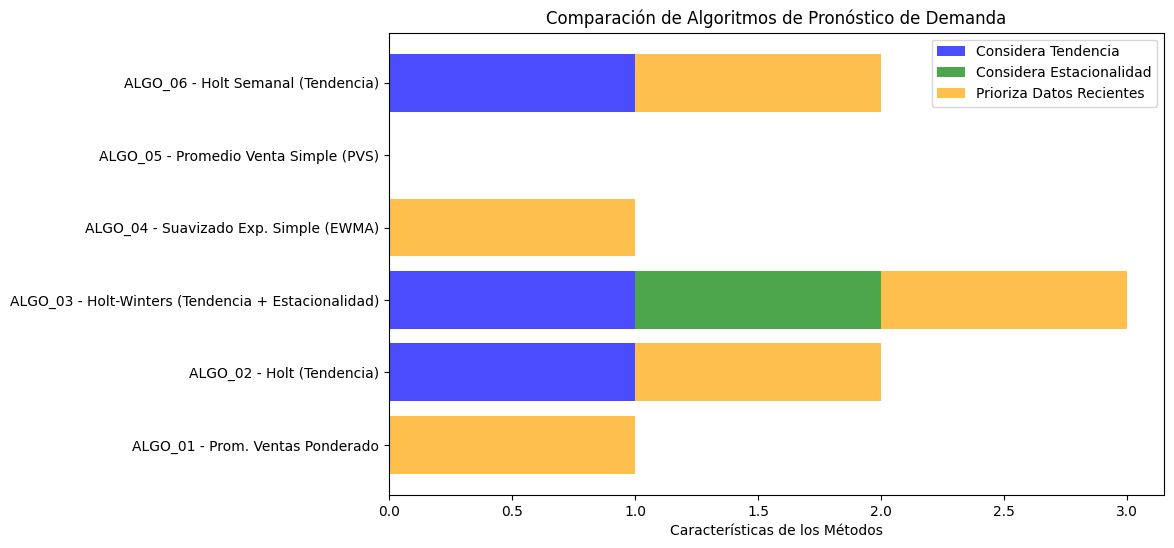

In [1]:
import matplotlib.pyplot as plt

# Definir los métodos y sus características principales
metodos = [
    "ALGO_01 - Prom. Ventas Ponderado",
    "ALGO_02 - Holt (Tendencia)",
    "ALGO_03 - Holt-Winters (Tendencia + Estacionalidad)",
    "ALGO_04 - Suavizado Exp. Simple (EWMA)",
    "ALGO_05 - Promedio Venta Simple (PVS)",
    "ALGO_06 - Holt Semanal (Tendencia)"
]

# Características de cada método (valores ficticios para visualización)
considera_tendencia = [0, 1, 1, 0, 0, 1]  # 1 si considera tendencia, 0 si no
considera_estacionalidad = [0, 0, 1, 0, 0, 0]  # 1 si considera estacionalidad, 0 si no
prioriza_datos_recientes = [1, 1, 1, 1, 0, 1]  # 1 si da más peso a datos recientes, 0 si no

# Crear el gráfico de radar
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(metodos, considera_tendencia, color='blue', alpha=0.7, label="Considera Tendencia")
ax.barh(metodos, considera_estacionalidad, color='green', alpha=0.7, left=considera_tendencia, label="Considera Estacionalidad")
ax.barh(metodos, prioriza_datos_recientes, color='orange', alpha=0.7, left=[sum(x) for x in zip(considera_tendencia, considera_estacionalidad)], label="Prioriza Datos Recientes")

ax.set_xlabel("Características de los Métodos")
ax.set_title("Comparación de Algoritmos de Pronóstico de Demanda")
ax.legend()
plt.show()
